# Design a complex value FIR filter based on frequency response

In certain situations, a complex-valued Finite Impulse Response (FIR) filter can be used to transform the frequency domain of input signals. For instance, applying a FIR filter can help flatten the frequency domain and reduce distortion caused by flatness issues in Intermediate Frequency (IF) chains.

In this notebook, I will demonstrate a methodology for designing a complex-value filter based on its frequency response, with the goal of simulating the IF flatness issue.

## 1 Frequency Flatness
Initially, I established a set of amplitudes to represent the flatness characteristics in the frequency domain.

In [1]:
import numpy as np
import scipy
import scipy.interpolate
%matplotlib inline
from matplotlib import pyplot as plt

freq_axis = np.array([-51.84, -44.16, -36.47, -28.79, -21.11, -13.43, -5.75, 1.94,
                      9.62, 17.3, 24.98, 32.66, 40.34, 48.03])*1e6
amplitudes = np.array([-375, -135, -202, -79, 1, 21, 15, 16, 91, 58, 89, 99, 128, 117])/1e2

# 2 Design a complex-value filter
To design a filter to simulating the flatness effect consists several steps:
1. Interpolating in-band amplitudes of flatness in accordance with the order of target filter.  
For instance, I consider a 4096-order FIR filter operated at sample rate of 122.88 MHz. So I employed a cubic spline interpolation to interpolate the amplitudes from 14 to 4097 samples.

Text(0, 0.5, 'Amplitude/dB')

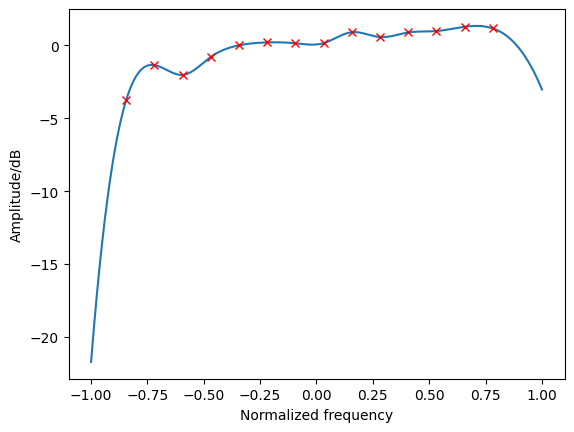

In [3]:
fs = 122.88e6  # Define IF sample rate
order = 4096   # Order of FIR filter
N = order + 1  # Number of filter's coef

## Interpolate amplitude based on FFT frequency axis.
freq_axis_norm = freq_axis / fs * 2  # normalize frequency axis to [-1, 1]
f_fft = np.arange(-1+2.0/N, 1+2.0/N, 2.0/N)
interp = scipy.interpolate.CubicSpline(freq_axis_norm, amplitudes)
amplitude_interp = interp(f_fft)
amplitude_interp_mag = 10**(amplitude_interp/20)

## Illustrate the interpolated amplitudes and original samples
plt.plot(f_fft, amplitude_interp)
plt.plot(freq_axis_norm, amplitudes, 'rx')
plt.xlabel("Normalized frequency")
plt.ylabel("Amplitude/dB")

2. Design a Low-pass filter to avoid out-band effect
3. Transform the coefficients of LPF into frequency domain by FFT, and multiply with interpolated amplitudes then translate back
to time domain.

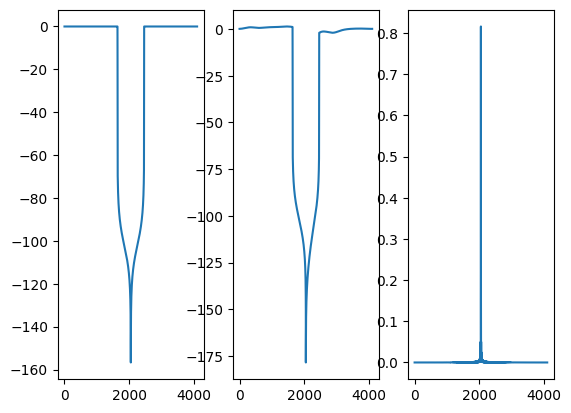

In [5]:
import scipy.signal

lpf_coef = scipy.signal.firwin(N, 273*12/4096)
lpf_f = np.fft.fft(lpf_coef)
h = np.fft.ifft(np.fft.fftshift(amplitude_interp_mag) * lpf_f)

## Visualize the
plt.subplot(1,3,1)
plt.plot(20*np.log10(abs(lpf_f)))
plt.subplot(1,3,2)
plt.plot(20*np.log10(abs(np.fft.fftshift(amplitude_interp_mag) * lpf_f)))
plt.subplot(1,3,3)
plt.plot(abs(h))